<a href="https://colab.research.google.com/github/camiceolin05-hash/BIG-DATA/blob/main/MEUS%20PROJETOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#bloco 1 - carregamento das bibilotecas
from timeit import default_timer
start = default_timer()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [17]:
#Bloco 2 Importar os arquivos para a memória do APP
st = default_timer()
movies = pd.read_csv('/content/movie.csv')
ratings = pd.read_csv('/content/rating.csv', names=['userId', 'movieId', 'rating', 'timestamp'], skiprows=1)

In [18]:
# Bloco 3 Processamento e limpeza de dados
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object


/tmp/ipython-input-18-2567769217.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)


Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  41.7


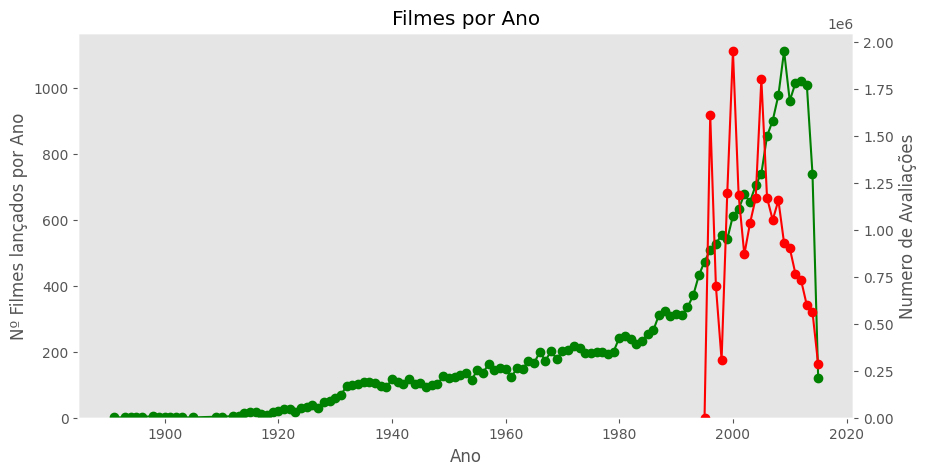

Elapsed time(sec):  1.27


/tmp/ipython-input-24-3285457546.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<Figure size 1000x500 with 0 Axes>

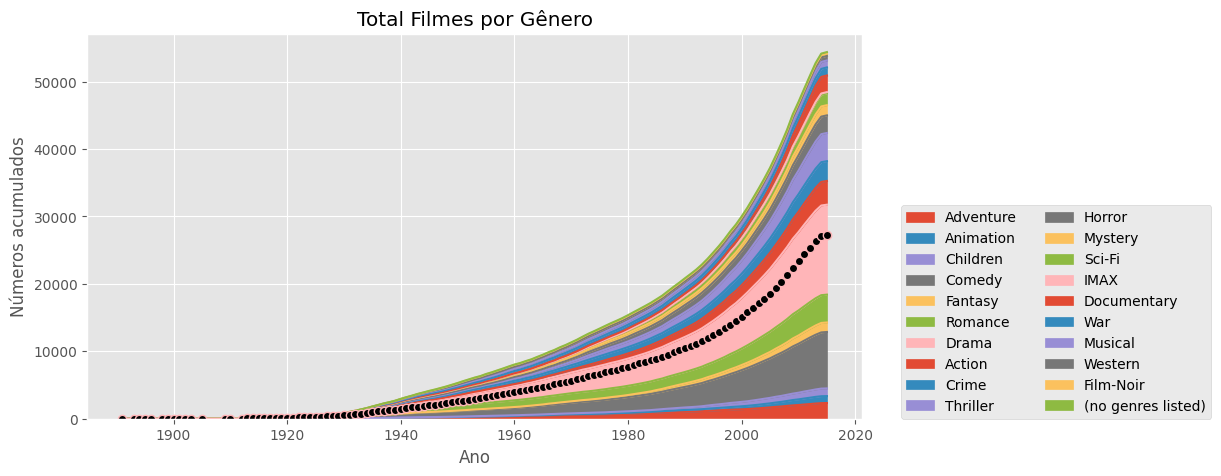

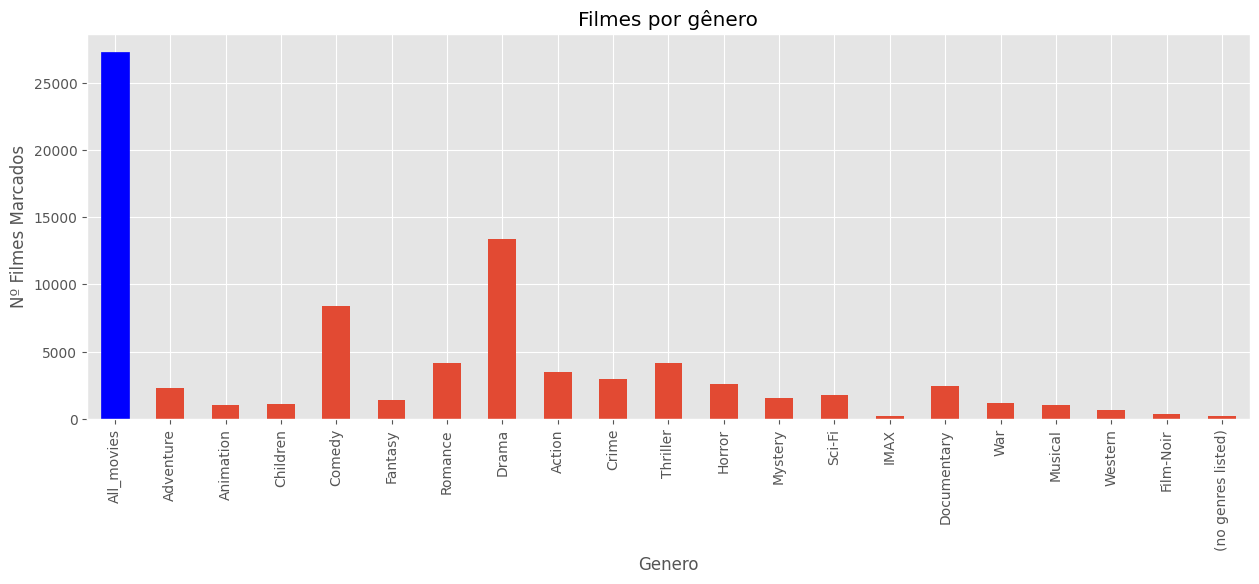

Elapsed time(sec):  0.54


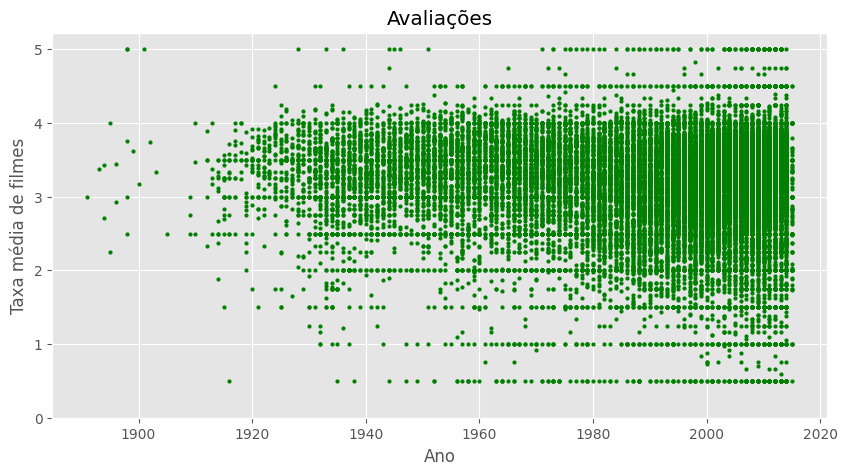

Elapsed time(sec):  0.63


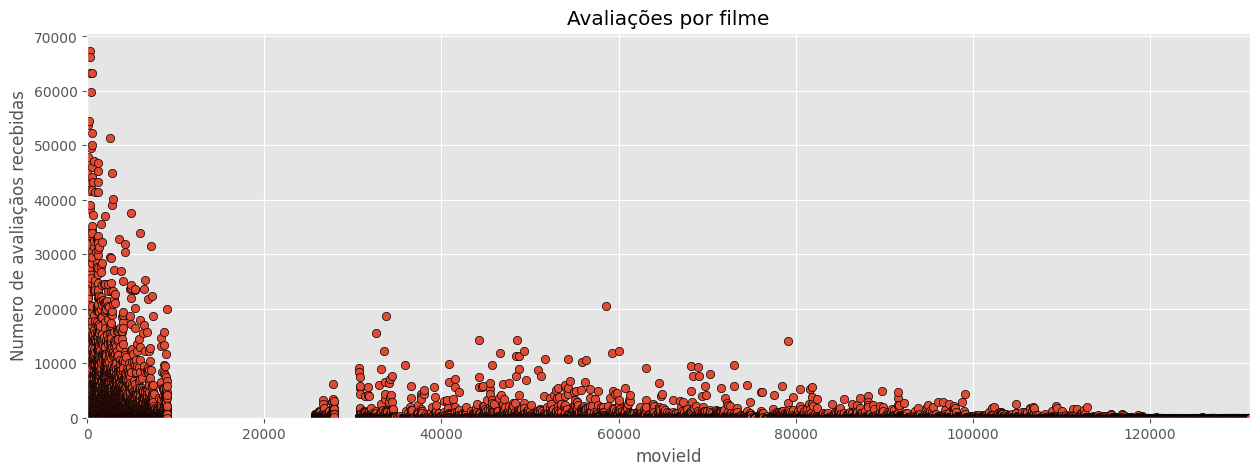

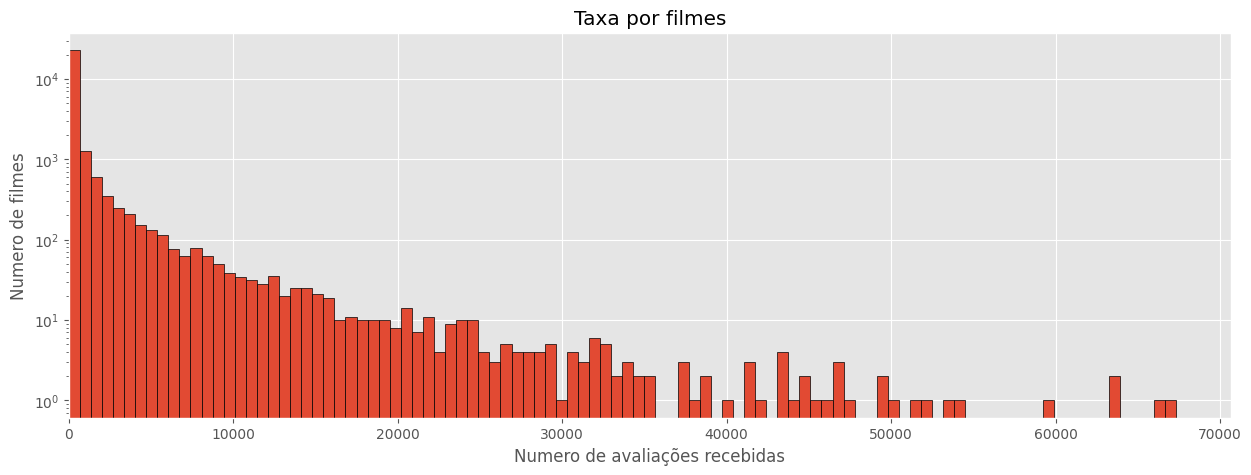

Elapsed time(sec):  0.77


In [24]:
st = default_timer()

# Trabalhar com uma fatia temporária menor 'dftmp' do dataframe original para reduzir o tempo de execução (as classificações têm +2 milhões de linhas)

dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Ano')
ax1.set_ylabel('Nº Filmes lançados por Ano'); ax2.set_ylabel('Numero de Avaliações')
plt.title('Filmes por Ano')
plt.show()

# Limpeza
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Histograma do gráfico para cada gênero individual
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Histograma de plotagem para todos os filmes
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Ano')
plt.ylabel('Números acumulados')
plt.title('Total Filmes por Gênero') # Muitos filmes têm vários gêneros, então o número de filmes é maior que o número de filmes
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Traçar uma dispersão simples do número de filmes marcados com cada gênero
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Colorir 'All_movies' de forma diferente, pois não é uma contagem de tags de gênero
plt.xticks(rotation='vertical')
plt.title('Filmes por gênero')
plt.xlabel('Genero')
plt.ylabel('Nº Filmes Marcados')
plt.show()

# Limpeza
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Ano')
plt.ylabel('Taxa média de filmes')
plt.title('Avaliações')
plt.ylim(0,)
plt.show()

# Limpeza
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

st = default_timer()

# O gráfico de dispersão de todos os usuários e avaliações individuais conta.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Avaliações por filme')
plt.xlabel('movieId')
plt.ylabel('Numero de avaliaçãos recebidas')
plt.show()

# Histograma de contagens de classificações.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Taxa por filmes')
plt.xlabel('Numero de avaliações recebidas')
plt.ylabel('Numero de filmes')
plt.xlim(0,)
plt.show()


# Limpeza
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [25]:
movies.to_csv('movies.csv', index=False)

ratings.to_csv('ratings.csv', index=False)

print("\nDados exportados para 'movies.csv' e 'ratings.csv'.")


Dados exportados para 'movies.csv' e 'ratings.csv'.
